In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt

In [2]:
input_fname = 'test.original.in'
# np.set_printoptions(formatter={'float': lambda x: format(x, '1.4E')})

In [3]:
beam, lattice = impact.readInputFile(input_fname);
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

nturn = 1024
betx = 1.892632003629
alfx = 1.37638192047
emitxN = 0.0

beam.nCore_y = 1
beam.nCore_z = 1
beam.distribution.emitx = emitxN
beam.n_particles = 1

NL_t = 0.45
NL_c = 0.009

reading ImpactZ input file (test.original.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
beamTmp = copy(beam)
beamTmp.distribution.distribution_type = 'Waterbag'

In [5]:
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]
lattice.pop(0);
lattice[0].turns=nturn
lattice[1].n_sckick = 100
testLat = [copy(lattice[0])]
testLat[0].turns=0

In [6]:
print(beamTmp.distribution)


 distribution_type: 'Waterbag'
              mode: 'twiss'
              betz: 2324215873134.486 [degree/MeV]
              alfz: 0.0
             emitz: 6.89396745963425e-09 [degree-MeV]
            scalez: 1.0 [1.0]
           scalepz: 1.0 [1.0]
           offsetz: 0.0 [degree]
          offsetpz: 0.0 [MeV]
              betx: 2576.919407166738 [m]
              alfx: 0.0
             emitx: 0.0 [m-rad]
            scalex: 1.0 [1.0]
           scalepx: 1.0 [1.0]
           offsetx: 0.0 [m]
          offsetpx: 0.0 [rad]
              bety: 2576.919407166738 [m]
              alfy: 0.0
             emity: 1.460965201818848e-07 [m-rad]
            scaley: 1.0 [1.0]
           scalepy: 1.0 [1.0]
           offsety: 0.0 [m]
          offsetpy: 0.0 [rad]


In [7]:
impact.writeInputFile(beamTmp,testLat)
impact.run(beamTmp)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

In [8]:
print(beamTmp.distribution)


 distribution_type: 'Waterbag'
              mode: 'impactdist'
            sigmax: 0.0
           lambdax: 0.0
               mux: 0.0
            scalex: 1.0 [1.0]
           scalepx: 1.0 [1.0]
           offsetx: 0.0 [m]
          offsetpx: 0.0 [rad]
            sigmay: 0.0007108541
           lambday: 0.000129223
               muy: 0.0
            scaley: 1.0 [1.0]
           scalepy: 1.0 [1.0]
           offsety: 0.0 [m]
          offsetpy: 0.0 [rad]
            sigmaz: 2.2092772151898727
           lambdaz: 1.065789e-10
               muz: 0.0
            scalez: 1.0 [1.0]
           scalepz: 1.0 [1.0]
           offsetz: 0.0 [degree]
          offsetpz: 0.0 [MeV]


In [9]:
np.linspace

<function numpy.core.function_base.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)>

In [10]:
nSample = 11
delta = 1.0e-6
Y=[]
pDataInit0 = impact.readParticleData(-111110,ke,mass,freq)
pDataInit  = impact.readParticleData(-111110,ke,mass,freq)
for offset in np.linspace(0.008-delta,0.008+delta,nSample):
    pDataInit[:,2] = pDataInit0[:,2] + offset
    impact.writeParticleData(pDataInit,ke,mass,freq)
    beam.distribution.distribution_type = 'ReadFile'
    impact.writeInputFile(beam,lattice)
    impact.run(beam)
    fort82=np.loadtxt('fort.82')
    Y.append(fort82[:,3] + 1j*fort82[:,4])

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


In [11]:
Tune=[0]*nSample
Amp =[0]*nSample
Y1  =[0]*nSample
for i in range(nSample):
    Tune[i],Amp[i],Y1[i] = impact.util.naff(1,Y[i])

In [12]:
def arcsin(z):
    return -1j*np.log(1j*z+np.sqrt(1.0-z**2))

def get_Inv1(x,px,y,py,c,t,alfa,beta):
    xn = x/(c*beta**0.5)
    pxn = x*alfa/(c*beta**0.5) + px*beta**0.5/c
    yn = y/(c*beta**0.5)
    pyn = y*alfa/(c*beta**0.5) + py*beta**0.5/c
    z = xn+1j*yn
    H = z/np.sqrt(1.0-z**2)*arcsin(z)
    H = 0.5*(xn**2+yn**2+pxn**2+pyn**2) - t*np.real(H)
    return H

def get_emit(x,p,alfa,beta):
    xn = x/(c*beta**0.5)
    pxn = x*alfa/(c*beta**0.5) + px*beta**0.5/c
    yn = y/(c*beta**0.5)
    pyn = y*alfa/(c*beta**0.5) + py*beta**0.5/c
    z = xn+1j*yn
    H = z/np.sqrt(1.0-z**2)*arcsin(z)
    H = 0.5*(xn**2+yn**2+pxn**2+pyn**2) - t*np.real(H)
    return H

[-0.0079635]


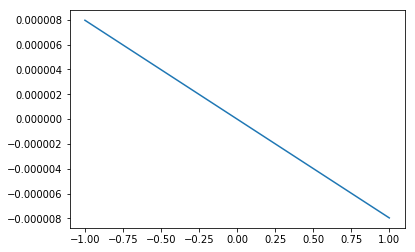

In [22]:
plt.plot(np.linspace(-delta,delta,nSample)*1.0e6,Tune-Tune[int(nSample/2)])
print((Tune[-1]-Tune[0])/(2*delta*1.0e3))

[-0.04406951]


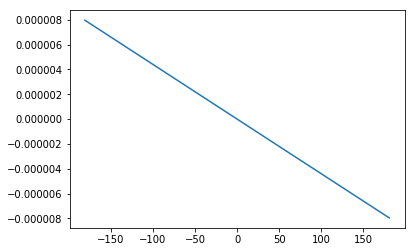

In [19]:
I1list = []
for y in np.linspace(0.008-delta,0.008+delta,nSample):
    I1list.append(get_Inv1(0,0,y,0,lattice[1].transverse_scale_c,lattice[1].strength_t,alfx,betx))
plt.plot((I1list-I1list[int(nSample/2)])*1.0e6,Tune-Tune[int(nSample/2)])
print((Tune[-1]-Tune[0])/(I1list[-1]-I1list[0]))

In [ ]:
plt.plot(np.linspace(-delta,delta,nSample)*1.0e6,Tune-Tune[int(nSample/2)])
print((Tune[-1]-Tune[0])/(2*delta*1.0e3))